Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/work-with-data/datadrift-tutorial/datadrift-quickdemo.png)

# Analyze data drift in Azure Machine Learning datasets 

In this tutorial, you will setup a data drift monitor on a weather dataset to:

&#x2611; Analyze historical data for drift

&#x2611; Setup a monitor to recieve email alerts if data drift is detected going forward

If your workspace is Enterprise level, view and exlpore the results in the Azure Machine Learning studio. The video below shows the results from this tutorial. 

![gif](media/video.gif)

## Prerequisites
If you are using an Azure Machine Learning Compute instance, you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) if you haven't already established your connection to the AzureML Workspace.

In [1]:
# Check core SDK version number
import azureml.core

print('SDK version:', azureml.core.VERSION)

SDK version: 1.36.0


## Initialize Workspace

Initialize a workspace object from persisted configuration.

In [2]:
from azureml.core import Workspace

ws = Workspace.from_config()
ws

Workspace.create(name='mlwspc2022', subscription_id='03588139-a541-41f5-a712-e635916119b9', resource_group='mlwspc2022')

## Setup target and baseline datasets

Setup the baseline and target datasets. The baseline will be used to compare each time slice of the target dataset, which is sampled by a given frequency. For further details, see [our documentation](http://aka.ms/datadrift). 

The next few cells will:
  * get the default datastore
  * upload the `weather-data` to the datastore
  * create the Tabular dataset from the data
  * add the timeseries trait by specifying the timestamp column `datetime`
  * register the dataset
  * create the baseline as a time slice of the target dataset
  * optionally, register the baseline dataset
  
The folder `weather-data` contains weather data from the [NOAA Integrated Surface Data](https://azure.microsoft.com/services/open-datasets/catalog/noaa-integrated-surface-data/) filtered down to to station names containing the string 'FLORIDA' to reduce the size of data. See `get_data.py` to see how this data is curated and modify as desired. This script may take a long time to run, hence the data is provided in the `weather-data` folder for this demo.

In [3]:
# use default datastore
dstore = ws.get_default_datastore()

In [4]:
# upload weather data
dstore.upload('weather-data', 'datadrift-data', overwrite=True, show_progress=True)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 118 files
Uploading weather-data/2010/01/data.parquet
Uploaded weather-data/2010/01/data.parquet, 1 files out of an estimated total of 118
Uploading weather-data/2010/02/data.parquet
Uploaded weather-data/2010/02/data.parquet, 2 files out of an estimated total of 118
Uploading weather-data/2010/03/data.parquet
Uploaded weather-data/2010/03/data.parquet, 3 files out of an estimated total of 118
Uploading weather-data/2010/04/data.parquet
Uploaded weather-data/2010/04/data.parquet, 4 files out of an estimated total of 118
Uploading weather-data/2010/05/data.parquet
Uploaded weather-data/2010/05/data.parquet, 5 files out of an estimated total of 118
Uploading weather-data/2010/06/data.parquet
Uploaded weather-data/2010/06/data.parquet, 6 files out of an estimated total of 118
Uploading weather-data/2010/07/data.parquet
Uploaded weather-data/2010/07/data.parquet, 7 files out of an estimated total of 118
Uploading weather-data/2010/09/data.parquet
Uploaded weather-

$AZUREML_DATAREFERENCE_33d0e19c0c004b958539ccdfa84b4cd2

In [5]:
# import Dataset class
from azureml.core import Dataset

# create target dataset 
target = Dataset.Tabular.from_parquet_files(dstore.path('datadrift-data/**/data.parquet'))
# set the timestamp column
target = target.with_timestamp_columns('datetime')
# register the target dataset
target = target.register(ws, 'target')
# retrieve the dataset from the workspace by name
target = Dataset.get_by_name(ws, 'target')

In [6]:
# import datetime 
from datetime import datetime

# set baseline dataset as January 2019 weather data
baseline = Dataset.Tabular.from_parquet_files(dstore.path('datadrift-data/2019/01/data.parquet'))

In [15]:
# optionally, register the baseline dataset. if skipped, an unregistered dataset will be used
baseline = baseline.register(ws, 'baseline')

## Create compute target

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

Create an Azure Machine Learning compute cluster to run the data drift monitor and associated runs. The below cell will create a compute cluster named `'cpu-cluster'`. 

In [7]:
from azureml.core.compute import AmlCompute, ComputeTarget

compute_name = 'cpu-cluster'

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2', min_nodes=0, max_nodes=2)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
InProgress..
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Resizing', 'allocationStateTransitionTime': '2022-01-04T22:39:36.985000+00:00', 'errors': None, 'creationTime': '2022-01-04T22:39:36.531165+00:00', 'modifiedTime': '2022-01-04T22:39:42.133551+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT1800S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D3_V2'}


## Create data drift monitor

See [our documentation](http://aka.ms/datadrift) for a complete description for all of the parameters. 

In [8]:
from azureml.datadrift import DataDriftDetector, AlertConfiguration

alert_config = AlertConfiguration(['user@contoso.com']) # replace with your email to recieve alerts from the scheduled pipeline after enabling

monitor = DataDriftDetector.create_from_datasets(ws, 'weather-monitor', baseline, target, 
                                                      compute_target='cpu-cluster',         # compute target for scheduled pipeline and backfills 
                                                      frequency='Week',                     # how often to analyze target data
                                                      feature_list=None,                    # list of features to detect drift on
                                                      drift_threshold=None,                 # threshold from 0 to 1 for email alerting
                                                      latency=0,                            # SLA in hours for target data to arrive in the dataset
                                                      alert_config=alert_config)            # email addresses to send alert

## Update data drift monitor

Many settings of the data drift monitor can be updated after creation. In this demo, we will update the `drift_threshold` and `feature_list`. See [our documentation](http://aka.ms/datadrift) for details on which settings can be changed.

In [9]:
# get monitor by name
monitor = DataDriftDetector.get_by_name(ws, 'weather-monitor')

# create feature list - need to exclude columns that naturally drift or increment over time, such as year, day, index
columns  = list(baseline.take(1).to_pandas_dataframe())
exclude  = ['year', 'day', 'version', '__index_level_0__']
features = [col for col in columns if col not in exclude]

# update the feature list
monitor  = monitor.update(feature_list=features)

Current state: Disabled
2022-01-04 22:40:15,835 - azureml.datadrift._logging._telemetry_logger.azureml.datadrift.datadriftdetector - WARNING - Alert has not been setup. Datadriftdetector with id: 8069a537-4a2a-4d3b-aef7-e38c1a3cb6fe.
This may be because you do not have access to the AppInsights associated with this AzureML Workspace - activity_id:18511524-e78e-4957-ae99-5d15637c510c activity_name:update activity_type:InternalCall tenant_id:None subscription_id:03588139-a541-41f5-a712-e635916119b9 resource_group:mlwspc2022 workspace_id:6c3daf74-56ad-4ce6-b604-cdc7a8ffaa52 workspace_location:westus2 compute_type:None compute_size:None compute_nodes_min:None compute_nodes_max:None image_id:None dd_id:8069a537-4a2a-4d3b-aef7-e38c1a3cb6fe dd_type:DatasetBased freq:Week interval:1 scheduling:Disabled threshold:None latency:0 total_features:0 services:None train_dataset_id:None baseline_dataset_id:07fb36f3-29ce-4727-a9d1-a01200685087 target_dataset_id:ad3e4ba8-c58d-46c6-936c-428503de7de8 log_

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/datadrift/datadriftdetector.py:1371: UserWarning: Alert has not been setup. Datadriftdetector with id: 8069a537-4a2a-4d3b-aef7-e38c1a3cb6fe.
This may be because you do not have access to the AppInsights associated with this AzureML Workspace
  warnings.warn(error_msg)


## Analyze historical data and backfill

You can use the `backfill` method to:
  * analyze historical data
  * backfill metrics after updating the settings (mainly the feature list)
  * backfill metrics for failed runs
  
The below cells will run two backfills that will produce data drift results for 2019 weather data, with January used as the baseline in the monitor. The output can be seen from the `show` method after the runs have completed, or viewed from the Azure Machine Learning studio for Enterprise workspaces.

![Drift results](media/drift-results.png)

>**Tip!** When starting with the data drift capability, start by backfilling on a small section of data to get initial results. Update the feature list as needed by removing columns that are causing drift, but can be ignored, and backfill this section of data until satisfied with the results. Then, backfill on a larger slice of data and/or set the alert configuration, threshold, and enable the schedule to recieve alerts to drift on your dataset. All of this can be done through the UI (Enterprise) or Python SDK.

Although it depends on many factors, the below backfill should typically take less than 20 minutes to run. Results will show as soon as they become available, not when the backfill is completed, so you may begin to see some metrics in a few minutes.

In [10]:
# backfill for one month
backfill_start_date = datetime(2019, 9, 1)
backfill_end_date = datetime(2019, 10, 1)
backfill = monitor.backfill(backfill_start_date, backfill_end_date)
backfill

Run(Experiment: weather-monitor-Monitor-Runs,
Id: weather-monitor-Monitor-Runs_1641336291992,
Type: DatasetDriftRunBackFill,
Status: Preparing)

## Query metrics and show results in Python

The below cell will plot some key data drift metrics, and can be used to query the results. Run `help(monitor.get_output)` for specifics on the object returned.

In [11]:
# make sure the backfill has completed
backfill.wait_for_completion(wait_post_processing=True)

{'runId': 'weather-monitor-Monitor-Runs_1641336291992',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-01-04T23:18:15.764491Z',
 'endTimeUtc': '2022-01-04T23:27:39.055027Z',
 'services': {},
 'warnings': [{'message': 'This run might be using a new job runtime with improved performance and error reporting. The logs from your script are in user_logs/std_log.txt. Please let us know if you run into any issues, and if you would like to opt-out, please add the environment variable AZUREML_COMPUTE_USE_COMMON_RUNTIME to the environment variables section of the job and set its value to the string "false"'}],
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '126034d3-7605-464b-b618-31da75de67ea',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '07fb36f3-29ce-4727-a9d1-a01200685087'}, 'consumptionDetails': {'type': 'Reference'}}, {'da

In [12]:
# get results from Python SDK (wait for backfills or monitor runs to finish)
results, metrics = monitor.get_output(start_time=datetime(year=2019, month=9, day=1))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


{'weather-monitor': <Figure size 1440x576 with 2 Axes>}

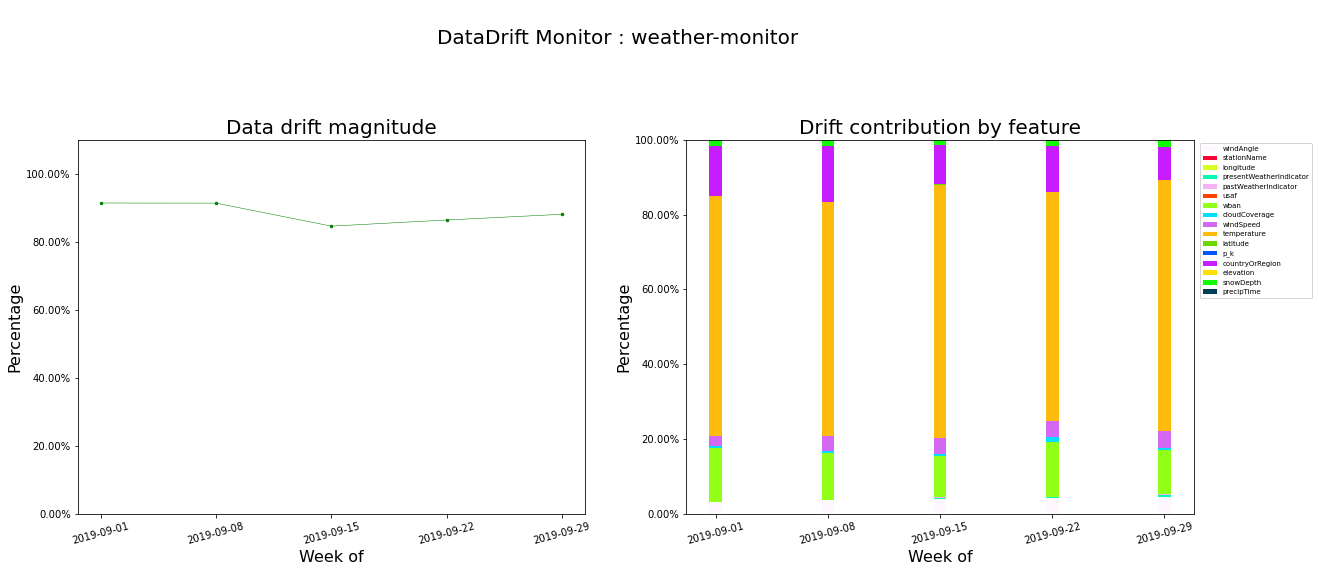

In [13]:
# plot the results from Python SDK 
monitor.show(backfill_start_date, backfill_end_date)

## Enable the monitor's pipeline schedule

Turn on a scheduled pipeline which will anlayze the target dataset for drift every `frequency`. Use the latency parameter to adjust the start time of the pipeline. For instance, if it takes 24 hours for my data processing pipelines for data to arrive in the target dataset, set latency to 24. 

In [14]:
# enable the pipeline schedule and recieve email alerts
monitor.enable_schedule()

# disable the pipeline schedule 
#monitor.disable_schedule()

Current state: Enabling
....State transitioning completed, status: Enabled


## Delete compute target

Do not delete the compute target if you intend to keep using it for the data drift monitor scheduled runs or otherwise. If the minimum nodes are set to 0, it will scale down soon after jobs are completed, and scale up the next time the cluster is needed.

In [ ]:
# optionally delete the compute target
#compute_target.delete()

## Delete the DataDriftDetector

Invoking the `delete()` method on the object deletes the the drift monitor permanently and cannot be undone. You will no longer be able to find it in the UI and the `list()` or `get()` methods. The object on which delete() was called will have its state set to deleted and name suffixed with deleted. The baseline and target datasets and model data that was collected, if any, are not deleted. The compute is not deleted. The DataDrift schedule pipeline is disabled and archived.

In [ ]:
monitor.delete()

## Next steps

  * See [our documentation](https://aka.ms/datadrift) or [Python SDK reference](https://docs.microsoft.com/python/api/overview/azure/ml/intro)
  * [Send requests or feedback](mailto:driftfeedback@microsoft.com) on data drift directly to the team
  * Please open issues with data drift here on GitHub or on StackOverflow if others are likely to run into the same issue